Import Dependies

In [3]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l1, l2
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import os

Load Abalone Dataset (Regression)

In [4]:
abalone_df = pd.read_csv('abalone.csv')
abalone_df['Sex'] = abalone_df['Sex'].map({'M': 0, 'F': 1, 'I': 2})  # Encode categorical column
X_abalone = abalone_df.drop(columns=['Rings']).values
y_abalone = abalone_df['Rings'].values

Split data into train/test sets

In [5]:
X_train_abalone, X_test_abalone, y_train_abalone, y_test_abalone = train_test_split(X_abalone, y_abalone, test_size=0.2, random_state=42)

Load Iris Dataset (Classification)

In [6]:
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Split Iris data into train/test sets
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)

# 1. Create TensorFlow Data Pipeline

In [7]:
def preprocess(features, labels):
    features = tf.cast(features, dtype=tf.float32)
    labels = tf.cast(labels, dtype=tf.float32)
    return features, labels

train_dataset_abalone = tf.data.Dataset.from_tensor_slices((X_train_abalone, y_train_abalone))
train_dataset_abalone = train_dataset_abalone.shuffle(buffer_size=1024).batch(32).map(preprocess)

test_dataset_abalone = tf.data.Dataset.from_tensor_slices((X_test_abalone, y_test_abalone))
test_dataset_abalone = test_dataset_abalone.batch(32).map(preprocess)

2024-12-29 19:59:25.556852: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2024-12-29 19:59:25.556961: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: abishek-HP-Pavilion-17-Notebook-PC
2024-12-29 19:59:25.556983: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: abishek-HP-Pavilion-17-Notebook-PC
2024-12-29 19:59:25.557243: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 495.29.5
2024-12-29 19:59:25.557315: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.183.1
2024-12-29 19:59:25.557333: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:262] kernel version 535.183.1 does not match

# 2. Simple Linear Regression Model for Abalone

In [8]:
linear_model_abalone = Sequential([
    Dense(1, input_dim=X_train_abalone.shape[1], activation='linear')  # No activation for linear output
])

linear_model_abalone.compile(optimizer='adam', loss='mse')
linear_model_abalone.fit(X_train_abalone, y_train_abalone, epochs=50, validation_data=(X_test_abalone, y_test_abalone))

/home/abishek/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 106.4371 - val_loss: 99.9429
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 96.8227 - val_loss: 91.1058
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 89.8741 - val_loss: 82.9399
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81.0119 - val_loss: 75.4232
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 72.2276 - val_loss: 68.4980
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 66.7056 - val_loss: 62.1109
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 60.6992 - val_loss: 56.2768
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.5258 - val_loss: 50.9156
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.5330 - val_loss: 46.0492
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.0727 - val_loss: 41.6219
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 40.7818 - val_loss: 37.6160
Epoch 12/50
105/105 ━━━━━━━━━

# 3. Multi-layer Perceptron (MLP) Model for Abalone

In [9]:
mlp_model_abalone = Sequential([
    Dense(128, input_dim=X_train_abalone.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Linear output for regression
])

mlp_model_abalone.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mlp_model_abalone.fit(X_train_abalone, y_train_abalone, epochs=50, validation_data=(X_test_abalone, y_test_abalone), callbacks=[early_stopping])



Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 70.5740 - val_loss: 8.8597
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4937 - val_loss: 7.4017
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4761 - val_loss: 6.5629
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2756 - val_loss: 6.2904
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8826 - val_loss: 5.8918
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9393 - val_loss: 5.7344
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3430 - val_loss: 5.5072
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1995 - val_loss: 5.3585
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2185 - val_loss: 5.2943
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9581 - val_loss: 5.0683
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9953 - val_loss: 5.0162
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

# 4. Dropout Model for Abalone

In [10]:
dropout_model_abalone = Sequential([
    Dense(128, input_dim=X_train_abalone.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1)
])

dropout_model_abalone.compile(optimizer='adam', loss='mse')
dropout_model_abalone.fit(X_train_abalone, y_train_abalone, epochs=50, validation_data=(X_test_abalone, y_test_abalone), callbacks=[early_stopping])


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 64.9793 - val_loss: 9.2366
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9433 - val_loss: 8.0829
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9134 - val_loss: 7.3380
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6296 - val_loss: 6.5884
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.6668 - val_loss: 6.2008
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3735 - val_loss: 6.0298
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5321 - val_loss: 5.9469
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1620 - val_loss: 5.6880
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8354 - val_loss: 5.6526
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7102 - val_loss: 5.4154
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5430 - val_loss: 5.3931
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

# 5. Batch Normalization Model for Abalone

In [11]:
batch_norm_model_abalone = Sequential([
    Dense(128, input_dim=X_train_abalone.shape[1], activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(1)
])

batch_norm_model_abalone.compile(optimizer='adam', loss='mse')
batch_norm_model_abalone.fit(X_train_abalone, y_train_abalone, epochs=50, validation_data=(X_test_abalone, y_test_abalone), callbacks=[early_stopping])


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 45.2988 - val_loss: 49.5569
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.0529 - val_loss: 34.5099
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5953 - val_loss: 18.6168
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.4853 - val_loss: 12.5353
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0872 - val_loss: 7.4883
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1769 - val_loss: 5.7013
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7070 - val_loss: 4.6039
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7739 - val_loss: 5.8645
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8677 - val_loss: 5.2495
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7966 - val_loss: 4.8336
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.7371 - val_loss: 4.9019
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms

# 6. Custom Loss Function for Abalone

In [12]:
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred)) + 0.01 * tf.reduce_sum(tf.square(y_pred))

# 7. L1 Regularization Model for Abalone

In [13]:
l1_model_abalone = Sequential([
    Dense(128, input_dim=X_train_abalone.shape[1], activation='relu', kernel_regularizer=l1(0.01)),
    Dense(64, activation='relu'),
    Dense(1)
])

l1_model_abalone.compile(optimizer='adam', loss='mse')
l1_model_abalone.fit(X_train_abalone, y_train_abalone, epochs=50, validation_data=(X_test_abalone, y_test_abalone), callbacks=[early_stopping])


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 60.1525 - val_loss: 9.0019
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6156 - val_loss: 7.3204
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0780 - val_loss: 6.7078
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2502 - val_loss: 6.3706
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2133 - val_loss: 6.6778
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3008 - val_loss: 5.9682
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9830 - val_loss: 5.8066
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6718 - val_loss: 5.8115
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6224 - val_loss: 6.2487
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8542 - val_loss: 5.5707
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5963 - val_loss: 5.4760
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

# 8. L2 Regularization Model for Abalone

In [14]:
l2_model_abalone = Sequential([
    Dense(128, input_dim=X_train_abalone.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dense(64, activation='relu'),
    Dense(1)
])

l2_model_abalone.compile(optimizer='adam', loss='mse')
l2_model_abalone.fit(X_train_abalone, y_train_abalone, epochs=50, validation_data=(X_test_abalone, y_test_abalone), callbacks=[early_stopping])


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 70.7022 - val_loss: 8.9341
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1392 - val_loss: 7.3536
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1775 - val_loss: 6.5621
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5971 - val_loss: 6.2210
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0482 - val_loss: 5.9404
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6119 - val_loss: 6.2970
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5279 - val_loss: 5.6143
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5021 - val_loss: 5.5139
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0300 - val_loss: 5.4465
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.3516 - val_loss: 5.2847
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.4164 - val_loss: 5.3092
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/ste

# 9. Learning Rate Scheduling for Abalone

In [15]:
lr_scheduler_abalone = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)


# 10. Model Checkpointing for Abalone

In [16]:
checkpoint_abalone = ModelCheckpoint('best_model_abalone.keras', monitor='val_loss', save_best_only=True)

# 11. Train Model with TensorFlow Callbacks for Abalone

In [17]:
model_with_callbacks_abalone = Sequential([
    Dense(128, input_dim=X_train_abalone.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model_with_callbacks_abalone.compile(optimizer='adam', loss='mse')
model_with_callbacks_abalone.fit(X_train_abalone, y_train_abalone, epochs=50, validation_data=(X_test_abalone, y_test_abalone),
                                 callbacks=[early_stopping, lr_scheduler_abalone, checkpoint_abalone])


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 66.5916 - val_loss: 8.9519 - learning_rate: 0.0010
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1751 - val_loss: 7.4943 - learning_rate: 0.0010
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4703 - val_loss: 6.5556 - learning_rate: 0.0010
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.2743 - val_loss: 6.1315 - learning_rate: 0.0010
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7509 - val_loss: 5.8573 - learning_rate: 0.0010
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.4803 - val_loss: 5.6915 - learning_rate: 0.0010
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.4807 - val_loss: 5.4737 - learning_rate: 0.0010
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4785 - val_loss: 5.3743 - learning_rate: 0.0010
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.4891 - val_loss: 5.2310 - learning_rate: 0.0010
Epoch 10/

# 12. Custom Metric for Abalone: Mean Absolute Error

In [18]:
class CustomMAE(tf.keras.metrics.Metric):
    def __init__(self, name='custom_mae', **kwargs):
        super(CustomMAE, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure both y_true and y_pred are of the same dtype
        y_true = tf.cast(y_true, tf.float32)  # Convert y_true to float32 if it's int64
        abs_diff = tf.abs(y_true - y_pred)
        self.total.assign_add(tf.reduce_sum(abs_diff))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.total / self.count


# 13. Train with Custom Metric for Abalone

In [19]:
custom_metric_model_abalone = Sequential([
    Dense(128, input_dim=X_train_abalone.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

custom_metric_model_abalone.compile(optimizer='adam', loss='mse', metrics=[CustomMAE()])
custom_metric_model_abalone.fit(X_train_abalone, y_train_abalone, epochs=50, validation_data=(X_test_abalone, y_test_abalone), callbacks=[early_stopping])


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - custom_mae: 220.4287 - loss: 61.4750 - val_custom_mae: 99.3777 - val_loss: 8.7700
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - custom_mae: 97.5000 - loss: 8.1858 - val_custom_mae: 98.0746 - val_loss: 7.3479
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - custom_mae: 94.2768 - loss: 6.8039 - val_custom_mae: 92.3184 - val_loss: 6.4156
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - custom_mae: 92.5036 - loss: 6.3921 - val_custom_mae: 92.5689 - val_loss: 6.0257
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - custom_mae: 90.9350 - loss: 5.8799 - val_custom_mae: 96.0998 - val_loss: 5.8321
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - custom_mae: 90.6792 - loss: 5.4052 - val_custom_mae: 92.0293 - val_loss: 5.6697
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - custom_mae: 90.9194 - loss: 5.3551 - val_custom_mae: 94.2283 - val_loss: 5.4682
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - custom

# 14. TensorBoard for Visualization (Abalone)

In [29]:
tensorboard_callback_abalone = TensorBoard(log_dir=os.path.join('logs', 'abalone'))


# 15. Predict with the Model (Abalone)

In [21]:
sample_data_abalone = tf.convert_to_tensor(X_test_abalone[:5], dtype=tf.float32)
predictions_abalone = model_with_callbacks_abalone.predict(sample_data_abalone)
print("Sample Predictions (Abalone):", predictions_abalone)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Sample Predictions (Abalone): [[11.9023285]
 [10.266793 ]
 [14.382586 ]
 [11.635651 ]
 [11.423964 ]]


# Iris Dataset Classification Model (using MLP)
# 16. Multi-layer Perceptron (MLP) for Iris

In [22]:
mlp_model_iris = Sequential([
    Dense(128, input_dim=X_train_iris.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes for classification (Iris dataset)
])

mlp_model_iris.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model_iris.fit(X_train_iris, y_train_iris, epochs=50, validation_data=(X_test_iris, y_test_iris), callbacks=[early_stopping])


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.5079 - loss: 1.1822 - val_accuracy: 0.6667 - val_loss: 0.9333
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6331 - loss: 0.9176 - val_accuracy: 0.7000 - val_loss: 0.8518
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6988 - loss: 0.8438 - val_accuracy: 0.7000 - val_loss: 0.7945
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6881 - loss: 0.7927 - val_accuracy: 0.8333 - val_loss: 0.7550
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8231 - loss: 0.7390 - val_accuracy: 0.8667 - val_loss: 0.6943
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8900 - loss: 0.6877 - val_accuracy: 0.8667 - val_loss: 0.6504
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9075 - loss: 0.6302 - val_accuracy: 0.9000 - val_loss: 0.6086
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9227 - loss: 0.5859 - val_accuracy: 0.8667 - val_loss: 0.5671

# 17. Dropout for Iris Classification


In [23]:
dropout_model_iris = Sequential([
    Dense(128, input_dim=X_train_iris.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

dropout_model_iris.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dropout_model_iris.fit(X_train_iris, y_train_iris, epochs=50, validation_data=(X_test_iris, y_test_iris), callbacks=[early_stopping])


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.3248 - loss: 1.5353 - val_accuracy: 0.3000 - val_loss: 1.0535
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3410 - loss: 1.1001 - val_accuracy: 0.3667 - val_loss: 0.9873
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4475 - loss: 1.0306 - val_accuracy: 0.3667 - val_loss: 0.9402
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4619 - loss: 1.0000 - val_accuracy: 0.3667 - val_loss: 0.8593
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4960 - loss: 0.9095 - val_accuracy: 0.7000 - val_loss: 0.7700
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5775 - loss: 0.8803 - val_accuracy: 0.7000 - val_loss: 0.6920
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6956 - loss: 0.7617 - val_accuracy: 0.7000 - val_loss: 0.6368
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7215 - loss: 0.7123 - val_accuracy: 0.7000 - val_loss: 0.5837


# 18. Model Checkpointing for Iris

In [30]:
checkpoint_iris = ModelCheckpoint('best_model_iris.keras', monitor='val_loss', save_best_only=True)

# 19. Predict with the Iris Model


In [25]:
sample_data_iris = tf.convert_to_tensor(X_test_iris[:5], dtype=tf.float32)
predictions_iris = mlp_model_iris.predict(sample_data_iris)
print("Sample Predictions (Iris):", predictions_iris)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Sample Predictions (Iris): [[2.88879406e-03 7.83540726e-01 2.13570431e-01]
 [9.96594369e-01 3.40215582e-03 3.40490647e-06]
 [1.77446907e-06 6.17142860e-03 9.93826807e-01]
 [3.23458621e-03 7.55173743e-01 2.41591692e-01]
 [1.85153657e-03 8.90726924e-01 1.07421584e-01]]


In [26]:
# 1. Save the model for Abalone (Regression)
linear_model_abalone.save('best_model_abalone.keras')

# 2. Save the model for Iris (Classification)
mlp_model_iris.save('best_model_iris.keras')

# 19. Summary

In [27]:
linear_model_abalone.summary()
mlp_model_iris.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29 (120.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20 (84.00 B)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,275 (106.55 KB)

 Trainable params: 9,091 (35.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,184 (71.04 KB)

## Plotting

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


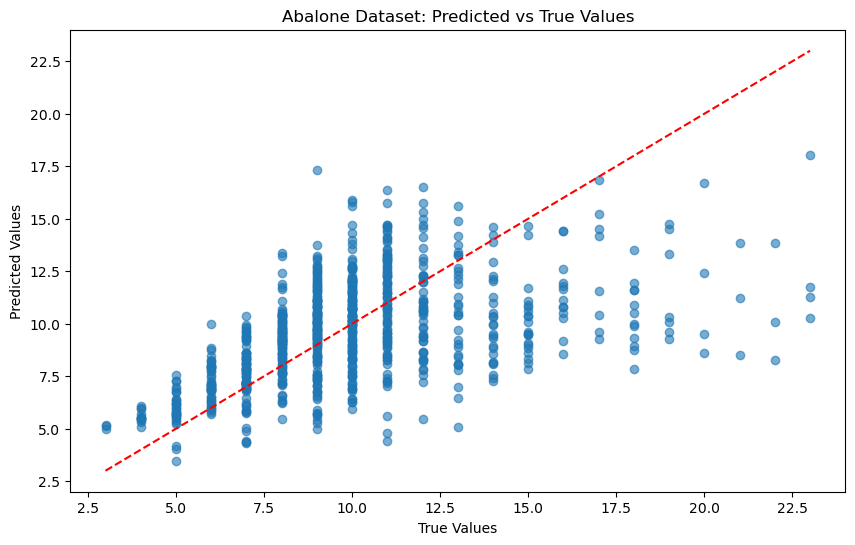

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


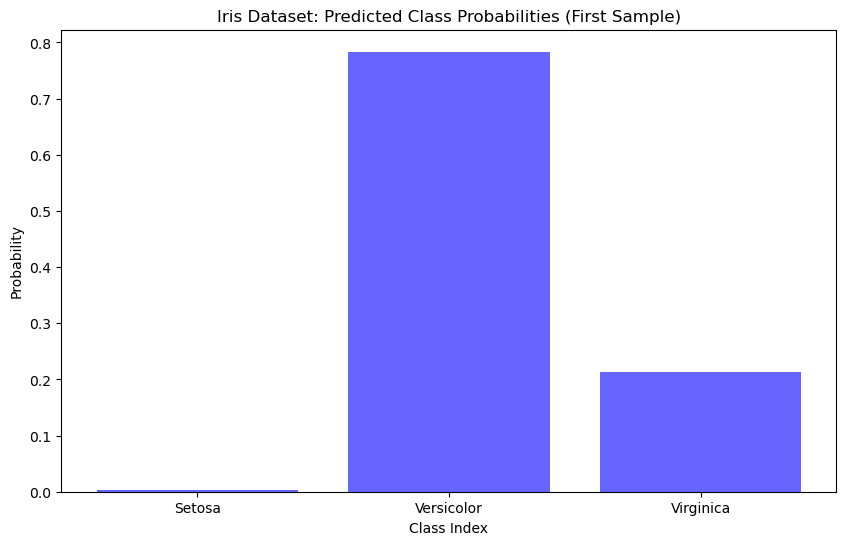

Predicted Classes (Iris): [1 0 2 1 1]


In [28]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 1. Load the saved model for Abalone (Regression)
best_model_abalone = load_model('best_model_abalone.keras')

# 2. Predict on test data for Abalone
predictions_abalone = best_model_abalone.predict(X_test_abalone)

# 3. Plot Predictions vs True Values for Abalone
plt.figure(figsize=(10, 6))
plt.scatter(y_test_abalone, predictions_abalone, alpha=0.6)
plt.plot([min(y_test_abalone), max(y_test_abalone)], [min(y_test_abalone), max(y_test_abalone)], color='r', linestyle='--')
plt.title('Abalone Dataset: Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# 4. Load the saved model for Iris (Classification)
best_model_iris = load_model('best_model_iris.keras')

# 5. Predict on test data for Iris
predictions_iris = best_model_iris.predict(X_test_iris)

# 6. Plot Predicted Probabilities for Iris (3 classes)
plt.figure(figsize=(10, 6))
plt.bar(range(len(predictions_iris[0])), predictions_iris[0], color='b', alpha=0.6, label='Prediction Probabilities')
plt.title('Iris Dataset: Predicted Class Probabilities (First Sample)')
plt.xlabel('Class Index')
plt.ylabel('Probability')
plt.xticks(range(3), ['Setosa', 'Versicolor', 'Virginica'])  # Iris class names
plt.show()

# 7. Optionally: Convert predictions to class labels for Iris
predicted_classes_iris = np.argmax(predictions_iris, axis=1)
print("Predicted Classes (Iris):", predicted_classes_iris[:5])
